In [2]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import dynamiqs as dq
import jax.numpy as jnp
from scipy.interpolate import RegularGridInterpolator
import cvxpy as cp
from scipy.linalg import sqrtm
import pandas as pd
from scipy.ndimage import gaussian_filter


In [3]:
def wigner_fct(x, y, data):
    xvec, yvec, W = data

    # # Ensure inputs are NumPy arrays
    # xvec = np.asarray(xvec)
    # yvec = np.asarray(yvec)
    # W = np.asarray(W)

    # # Create interpolator (lazy init is better in practice but kept inline here)
    # interp = RegularGridInterpolator((xvec, yvec), W.T)

    # # Interpolation expects array of shape (N, 2)
    # point = np.array([[x, y]])

    # return float(interp(point))  # Return scalar
    i = np.where(np.isclose(xvec, x))[0]
    j = np.where(np.isclose(yvec, y))[0]

    if len(i) == 0 or len(j) == 0:
        raise ValueError(f"Point (x={x}, y={y}) not found in grid.")

    return W[i[0], j[0]]

def pk(x, y, data):
    return 1/2 * (1 + np.pi/2 * wigner_fct(x, y, data))  # Return scalar

def measurement_operator(alpha, dim, original_dim=None):
    """
    Construct E_alpha for a given displacement alpha.

    If original_dim is provided, returns truncated operator of shape (original_dim, original_dim).
    """
    D = dq.displace(dim, alpha)
    P = dq.parity(dim)
    E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))

    if original_dim is not None and original_dim < dim:
        E = E.data  # unwrap before slicing
        E = E[:original_dim, :original_dim]
    else:
        E = E.data  # always unwrap for CVXPY use
    return E

def loss_cvxpy(rho_tilde, X, Y, data, dim, original_dim=None):
    alpha_k = (X + 1j * Y).ravel()
    points = np.stack([X.ravel(), Y.ravel()], axis=-1)
    target_p_k = np.array([pk(x, y, data) for x, y in points])

    pred_p_k = []
    for alpha in alpha_k:
        E = measurement_operator(alpha, dim, original_dim=original_dim)
        p = cp.real(cp.trace(E @ rho_tilde))
        pred_p_k.append(p)

    pred_p_k = cp.vstack(pred_p_k)
    target_p_k = target_p_k.reshape(-1, 1)

    return cp.sum_squares(pred_p_k - target_p_k) 

def fidelity(rho, rho_tilde):
    sqrt_rho = sqrtm(rho)
    inner = sqrt_rho @ rho_tilde @ sqrt_rho
    sqrt_inner = sqrtm(inner)
    return np.real(np.trace(sqrt_inner))**2

In [4]:
def fit_dm(data, rho_true, N, dim_ext, dim=10):
   
    # Choose displacement points
    # xmin, xmax = -3, 3
    # ymin, ymax = -3, 3


    # # Number of points per axis
    # #N = 50


    # # Generate grid of (x, y) values
    # x_vals = np.linspace(xmin, xmax, N)
    # y_vals = np.linspace(ymin, ymax, N)
   
    x_vals, y_vals, _ = data


    # Create 2D grid of x and y values
    X, Y = np.meshgrid(x_vals, y_vals, indexing="ij")


    rho = cp.Variable((dim, dim), complex=True)
    #rho = 0.5 * (rho + rho.H)


    constraints = [
        rho >> 0,
        cp.trace(rho) == 1,
        rho == rho.H
    ]


    loss_expr = loss_cvxpy(rho, X, Y, data, dim=dim_ext, original_dim=dim)
    problem = cp.Problem(cp.Minimize(loss_expr), constraints)
    problem.solve(solver=cp.SCS)


    print("Optimal value:", problem.value)
   
    if rho_true is not None:
        print("Fidelity:", fidelity(rho_true, rho.value))


        diag_true = np.real(np.diag(rho_true))
        diag_reco = np.real(np.diag(rho.value))


        # Print
        print("True diag:        ", np.round(diag_true, 5))
        print("Reconstructed diag:", np.round(diag_reco, 5))
       
        return fidelity(rho_true, rho.value)
   
    else:
        diag_reco = np.real(np.diag(rho.value))
        print("True diag:        ", np.round(diag_reco, 5))


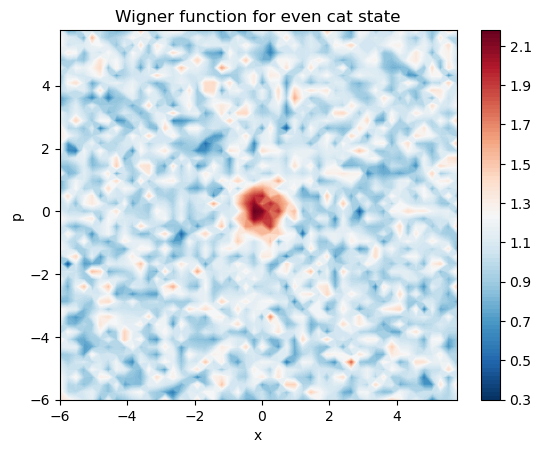

In [5]:
noisy_path = "C:/Users/solom/Desktop/AliceBob25/github/eth25_alice-bob_challenge/data/synthetic/noisy_wigner_0.pickle"
true_path = "C:/Users/solom/Desktop/AliceBob25/github/eth25_alice-bob_challenge/data/synthetic/quantum_state_0.pickle"

noisy_data = pkl.load(open(noisy_path, "rb"))
true_data = pkl.load(open(true_path, "rb"))
rho_true = true_data
rho_true = rho_true / np.trace(rho_true)

xvals, yvals, W = noisy_data[0], noisy_data[1], noisy_data[2]

x_selected = xvals[::20]
y_selected = yvals[::20]
wigner_selected = W[::20, ::20]

data = (x_selected, y_selected, wigner_selected)

plt.contourf(x_selected, y_selected, wigner_selected, levels=100, cmap="RdBu_r")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("p")
plt.title("Wigner function for even cat state")
plt.show()

In [6]:
# Inverse the affine transform

def estimate_b_robust(W, edge_width=10):
    """Estimate background offset b using only finite values on the edges."""
    edges = np.concatenate([
        W[:edge_width, :].ravel(),
        W[-edge_width:, :].ravel(),
        W[:, :edge_width].ravel(),
        W[:, -edge_width:].ravel()
    ])
    finite_edges = edges[np.isfinite(edges)]  # remove NaN, inf
    return np.mean(finite_edges)

def correct_affine_wigner(W, xvec, yvec, edge_width=10):
    """
    Corrects affine distortion in a Wigner function.

    Parameters:
    - W: 2D numpy array (Wigner function)
    - xvec, yvec: 1D arrays defining the phase space grid
    - edge_width: width of the boundary region for estimating b

    Returns:
    - W_corrected: 2D corrected Wigner function
    - a: normalization factor
    - b: background offset
    """
    dx = xvec[1] - xvec[0]
    dp = yvec[1] - yvec[0]

    # Estimate b from edge values
    b = estimate_b_robust(W, edge_width)

    # Estimate a from integral of (W - b)
    W_masked = np.where(np.isfinite(W), W, 0.0)  # zero out NaNs
    a = np.sum(W_masked - b) * dx * dp
    a = np.abs(a)  # ensure a is positive
    W_corrected = (W_masked - b) / a

    return W_corrected, a, b

def smooth_wigner(W, sigma):
    """
    Smooth the Wigner function using a Gaussian filter.

    Parameters:
    - W: 2D numpy array (Wigner function)
    - sigma: standard deviation for Gaussian kernel

    Returns:
    - W_smoothed: 2D smoothed Wigner function
    """
    return gaussian_filter(W, sigma=sigma)

In [20]:
sigma = np.linspace(0, 5, 10)

for s in sigma:
    xvals, yvals, W = noisy_data[0], noisy_data[1], noisy_data[2]
    # Gaussian filter
    W, a, b = correct_affine_wigner(W, xvals, yvals)
    W = smooth_wigner(W, s)

    x_selected = xvals[::20]
    y_selected = yvals[::20]
    wigner_selected = W[::20, ::20]

    data = (x_selected, y_selected, wigner_selected)
    fit_dm(data, rho_true, N = 0, dim_ext=60, dim=50)

C:\Users\solom\AppData\Local\Temp\ipykernel_23840\419493119.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))


Optimal value: 18.245427871657107
Fidelity: 0.14504193852129543
True diag:         [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Reconstructed diag: [0.14504 0.03308 0.01079 0.04572 0.02045 0.02207 0.01116 0.02029 0.01359
 0.02238 0.01355 0.03022 0.00959 0.01082 0.01343 0.02302 0.01272 0.01333
 0.01472 0.01476 0.01731 0.01661 0.01213 0.01217 0.01975 0.01804 0.01727
 0.01505 0.01296 0.01745 0.01133 0.02614 0.01832 0.01528 0.01628 0.01165
 0.02144 0.0238  0.01745 0.01052 0.02879 0.01028 0.01813 0.01338 0.01426
 0.0126  0.01805 0.01227 0.01891 0.02164]
Optimal value: 6.4969640787344645
Fidelity: 0.20459318343512028
True diag:         [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Reconstructed diag: [0.20459 0.05376 0.00841 0.03114 0.01661 0.02658 0.01169 0.02195 0.00983
 0.027

In [7]:
sigma = np.linspace(0, 10, 5)

for s in sigma:
    xvals, yvals, W = noisy_data[0], noisy_data[1], noisy_data[2]
    # Gaussian filter
    W, a, b = correct_affine_wigner(W, xvals, yvals)
    W = smooth_wigner(W, s)

    x_selected = xvals[::20]
    y_selected = yvals[::20]
    wigner_selected = W[::20, ::20]

    data = (x_selected, y_selected, wigner_selected)
    fit_dm(data, rho_true, N = 0, dim_ext=70, dim=50)

C:\Users\solom\AppData\Local\Temp\ipykernel_22520\419493119.py:35: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  E = 0.5 * (dq.eye(dim) + D @ P @ dq.dag(D))
c:\Users\solom\anaconda3\envs\alicebob25\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
c:\Users\solom\anaconda3\envs\alicebob25\Lib\site-packages\cvxpy\problems\problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


Optimal value: 18.230126790320757
Fidelity: 0.1807423175674904
True diag:         [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Reconstructed diag: [0.18074 0.02488 0.01016 0.03783 0.01571 0.03397 0.01829 0.01    0.0096
 0.01495 0.01289 0.01549 0.01339 0.01595 0.0128  0.02506 0.00771 0.01979
 0.0137  0.01313 0.01489 0.02015 0.01063 0.01166 0.01669 0.01613 0.01177
 0.01492 0.01124 0.01063 0.01617 0.02173 0.02014 0.02312 0.01363 0.01262
 0.02716 0.01034 0.02244 0.01324 0.02404 0.01141 0.0138  0.00959 0.02163
 0.02069 0.01387 0.01478 0.03259 0.01228]
Optimal value: 1.4850094009882966
Fidelity: 0.4255033017629843
True diag:         [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Reconstructed diag: [0.4255  0.0624  0.00467 0.01767 0.00707 0.02443 0.00638 0.018   0.00227
 0.01785 